## <center>PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle</center>

### Постановка задачи

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. 

### Цель проекта 

Построить модель на основе алгоритмов машинного обучения, которая предсказывает рейтинг отеля.

### Задачи проекта

1. ознакомиться с входными данными (датасет с информацией об отелях);
2. изучить пример машинного обучения (scikit-learn класс RandomForestRegressor);
3. выполнить подготовку данных, которые будут использованы для обучения модели;
4. проверить эффективность предлагаемой модели, используя метрику MAPE
5. принять участие в соревновании на площадке в kaggle.com.


Первоначальная версия датасета содержит 17 полей со следующей информацией:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве;
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
     
    
import re
import numpy as np

# Импортируем библиотеку для обработки естественного языка
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from collections import defaultdict

# Импортируем библиотеки для преобразования
import category_encoders as ce
from sklearn import preprocessing

# Импортируем библиотеки для обучения и оценки модели
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Скрываем warning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

### Загрузка и обработка данных

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Как видно из информации, в объединенном датасете 515738 строк и 18 столбцов. В столбцах lat и lng присутствуют пропущенные значения.

Проверим данные на наличие полных дубликатов

In [13]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 336


Заполним пропущенные значения

In [14]:
# # Получим пропущенные координаты при помощи геокодера
# from geopy.geocoders import Nominatim

# geolocator = Nominatim(user_agent = "hotels") 
# dict_coord = {} 

# # Получим список уникальных названий отелей с пропущенными значениями
# hotel_names = data[data['lat'].isnull() | data['lng'].\
#     isnull()]['hotel_name'].unique()

# # В цикла заполним словарь с названием отеля и его координатами
# for hotel in hotel_names:
#     coord = geolocator.geocode(hotel)
#     if coord :
#         dict_coord[hotel] = (coord.latitude, coord.longitude)
#     else:
#         dict_coord[hotel] = (0, 0)

# # Заполним пропущенные значения по индексам, соответствующим отелям
# for key in dict_coord:
#     index_hotels = data[data['hotel_name'] == key].index
#     data.loc[index_hotels, 'lat'] = dict_coord[key][0]
#     data.loc[index_hotels, 'lng'] = dict_coord[key][1]

In [15]:
# Получим список уникальных названий отелей с пропущенными значениями
hotel_names = data[data['lat'].isnull() | data['lng'].\
    isnull()]['hotel_name'].unique()
hotel_coord = [(48.220424, 16.355829), (48.220909, 16.366632), 
               (48.888909, 2.333142), (48.209408, 16.353434), 
               (48.213622, 16.379876), (48.209598, 16.35147),
               (41.391612, 2.177883), (48.188893, 16.383747), 
               (48.875359, 2.323402), (48.840038, 2.3235725), 
               (48.216835, 16.359894), (48.219569, 16.285592), 
               (41.392741, 2.167408), (48.246039, 16.341232),
               (48.186872, 16.420708), (48.233558, 16.345647),
               (41.383334, 2.162956)]

dict_coord = dict(zip(list(hotel_names), hotel_coord))

# Заполним пропущенные значения по индексам, соответствующим отелям
for key in dict_coord:
    index_data = data[data['hotel_name'] == key].index
    data.loc[index_data, 'lat'] = dict_coord[key][0]
    data.loc[index_data, 'lng'] = dict_coord[key][1]

In [16]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1489
lng                                             1489
sample                                             2
reviewer_score                                    38
dtype: int64

###  Визуальный анализ данныx

In [17]:
# Преобразуем признак days_since_review в числовой
data['days_since_review'] = data['days_since_review'].apply(
    lambda x: int(x.split(' ')[0]))

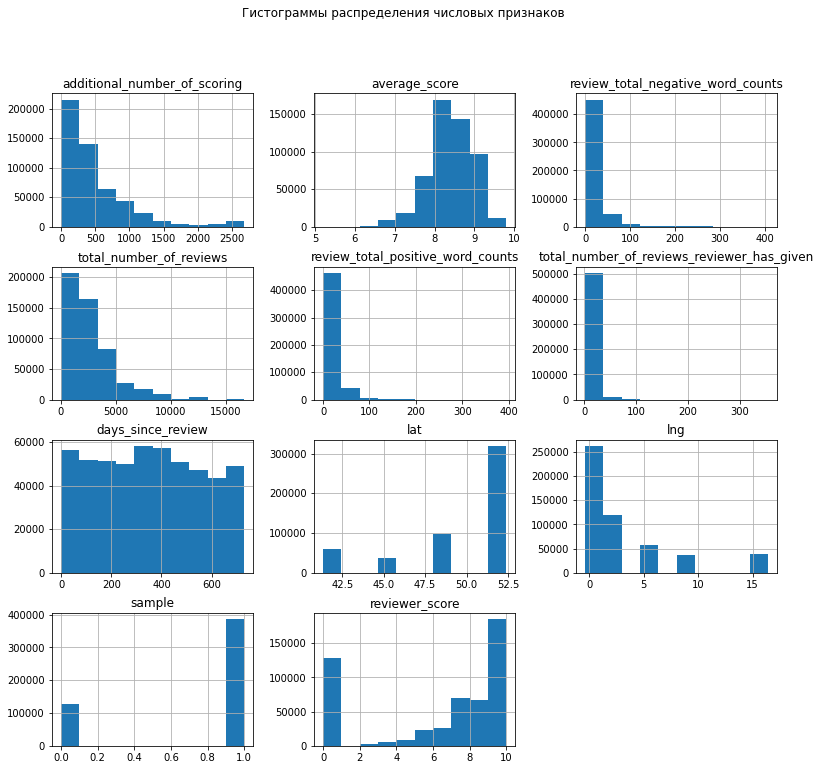

In [18]:
# Гистограммы распределения числовых признаков
fig, (ax1) = plt.subplots(1, figsize=(13, 12))
data.hist(ax=ax1)
plt.suptitle('Гистограммы распределения числовых признаков');

Как видно из графиков, ни один из признаков не распределен нормально. Для преобразования необходимо использовать нормализацию.

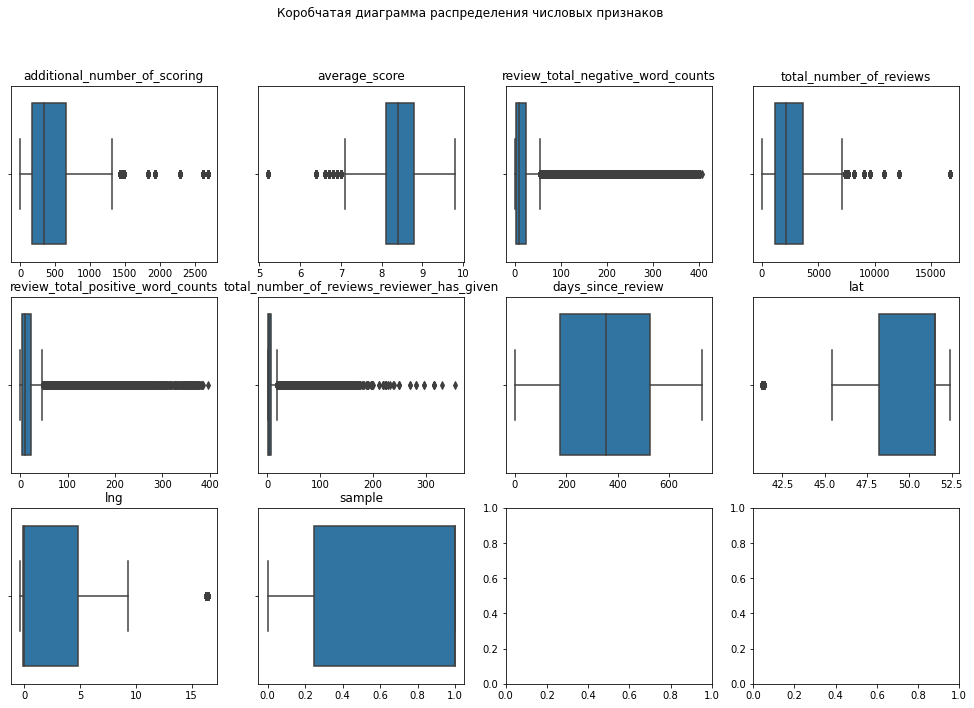

In [19]:
# Коробчатая диаграмма распределения числовых признаков
fig, axes = plt.subplots(3, 4, figsize=(17, 11))

cols = data.select_dtypes(include='number').columns
for i in range(10):
    sns.boxplot(data[cols[i]], ax=axes[i // 4][i % 4],
                orient='h')
    axes[i // 4][i % 4].set_title(cols[i])
    axes[i // 4][i % 4].set_xlabel('')
    
plt.suptitle('Коробчатая диаграмма распределения числовых признаков');

Из коробчатой диаграммы видно, что выбросы присутствуют во всех признаков, кроме day_since_review. Лучше использовать медиану.

In [20]:
# Статистические характеристики для количественных признаков
data.describe(include=['int64', 'float64'])

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,354.441932,49.432405,2.893479,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,208.928124,3.460242,4.667476,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,48.214066,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,51.499981,0.019886,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,527.000000,51.516288,4.841163,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,52.400181,16.429233,1.000000,10.000000


In [21]:
# Статистические характеристики для категориальных признаков
data.describe(include='object')

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags
count,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '..."
freq,4789,2585,4789,245246,127890,35946,5101


**Выводы по визуальному анализу**

Числовые признаки:

- additional_number_of_scoring находится в пределах от 1 до 2682 , среднее значение - 498, медиана - 341. Имеет смысл применить к нему нормализацию методом RobustScaler.

- average_score находится в пределах от 5.2 до 9.8, среднее значение и медиана оценки - 8.4. Данный признак гипотетически может внести большой вклад в предсказании рейтинга. Также можно применить нормализацию RobustScaler.

- review_total_negative_word_counts распределен в диапазоне от 0 до 408 слов, среднее значение - 18, медиана - 9 (нормализация RobustScaler). 

- total_number_of_reviews имеет размах от 43 до 16670 отзывов, среднее - 2744, медиана - 2134 (нормализация RobustScaler). 

- review_total_positive_word_counts находится в пределах от 0 до 395 слов, среднее значение - 18, медиана - 11 (нормализация RobustScaler). 

- total_number_of_reviews_reviewer_has_given имеет размах от 1 до 355 отзывов, среднее - 7, медиана - 3 (нормализация RobustScaler). 


- days_since_review находится в пределах от 0 до 730, среднее значение 354, медиана - 353. В данном признаке отсутствуют выбросы, можно применить нормализацию MinMaxScaler.

- lat на графике представлен 4 одинокими пеньками (нормализация RobustScaler).

- lng по аналогии с lat также нормализуем методом RobustScaler.

- reviewer_score распределен в диапазоне от 0 до 10, средняя оценка - 6.2, медиана - 7.9. Данный признак является целевым для предсказания.

Категориальные признаки:

- hotel_address имеет 1493 уникальных адресов. Частота самого популярного значения - 4789. Имеет смысл извлечь из адреса страну отеля.

- review_date имеет слишком много для категорий уникальных значений 731. Можно выделить квартал и проверить, какое отличие в распределении по временам года.

- hotel_name меет 1492 уникальных адресов. Видимо один из отелей имеет 2 адреса. Выделим ключевые слова в названии отелей и создадим по ним признаки.

- reviewer_nationality представлен 227 разными странами, но почти половина отзывов приходится на рецензентов из Великобритании. Посмотрим, влияет ли совпадении страны рецензента и страны отеля на оценку.

- negative_review и positive_review вносят самый большой вклад в оценку отеля. Проанализируем тональность отзывов и получим признаки с числовым выражением настроения. Необходимо учесть самые популярные сочетания слов - 'No Negative' и 'No Positive', которые носят положительные и отрицательные настроения соответственно.

- tags также имеет большое количество уникальных значений. Посчитаем количество тегов, извлечём из тегов информацию о количестве ночей, проведенных в отеле, а также вывведем информацию о наличии самого популярного тега.

### Создание новых признаков

In [22]:
# Функция визуализации графиков
def visualization(df, x, title, rotation):
    # Переименуем столбцы во избежании ошибки
    df.columns = [x, 'count_values', 'median_score']
    
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    
    df = df.sort_values('count_values', ascending=False)
    
    # Столбчатая диаграмма количества записей 
    sns.barplot(data=df, x=x, y='count_values', ax=axes[0])
    axes[0].set(ylabel='Количество')
    axes[0].set_title(title + ' по количеству записей')
    axes[0].tick_params(labelrotation=rotation, axis='x')
    
    df = df.sort_values('median_score', ascending=False)
    
    # Столбчатая диаграмма медианы рейтинга
    sns.barplot(data=df.sort_values('median_score', ascending=False),
                x=x, y='median_score', ax=axes[1])
    axes[1].set(ylabel='Средний рейтинг')
    axes[1].set_title(title + ' по медиане рейтинга отелей')
    axes[1].tick_params(labelrotation=rotation, axis='x')
    
    plt.show();

Создадим признак страны

In [23]:
data['hotel_country'] = data['hotel_address'].apply(
    lambda x: x.split(' ')[-1].replace('Kingdom', 'United Kingdom'))

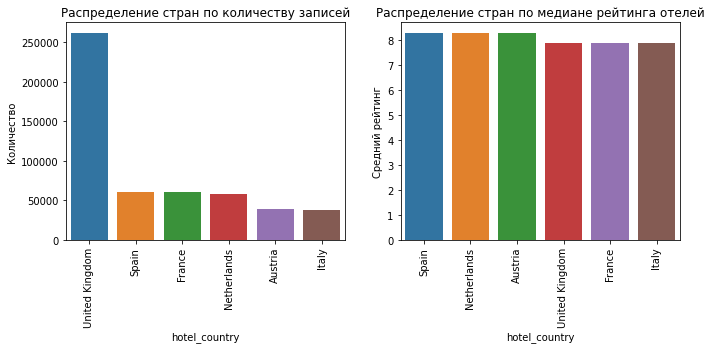

In [24]:
df = data.groupby('hotel_country')['reviewer_score'].agg(['count', 'median']).\
    reset_index('hotel_country')
visualization(df, 'hotel_country', 'Распределение стран', 90)

Из графиков видно, что у двух групп стран есть небольшое отличие по медиане рейтинга, а половина отзывов приходится на отели из Великобритании.

Создадим признак квартала отзыва

In [25]:
data['review_quarter'] = pd.to_datetime(data['review_date']).dt.quarter

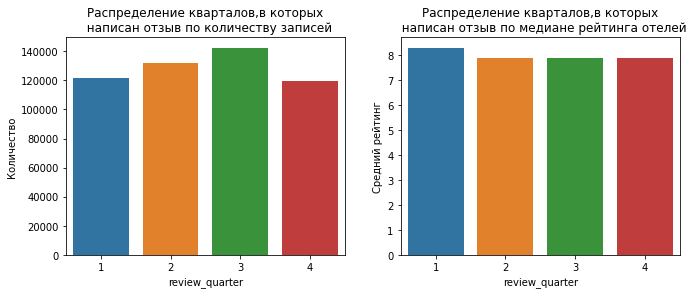

In [26]:
df = data.groupby('review_quarter')['reviewer_score'].agg(['count', 'median']).\
    reset_index('review_quarter')
visualization(df, 'review_quarter', 'Распределение кварталов,в которых\n  написан отзыв', 0)

На первый взгяд можно сказать, что принципиальное отличие в рейтинге присутсвует только у квартала 1, максимальное количество отзывов - у квартала 3.

Создадим список наличия ключевых слова в названии отелей

In [27]:
words = {'Park', 'Plaza', 'Holiday', 'Hilton', 'Grand', 'Palace', 'Royale'}
data['name_with_keyword'] = data['hotel_name'].apply(
       lambda x: 1 if set(x.split(' ')).intersection(words)  else 0)

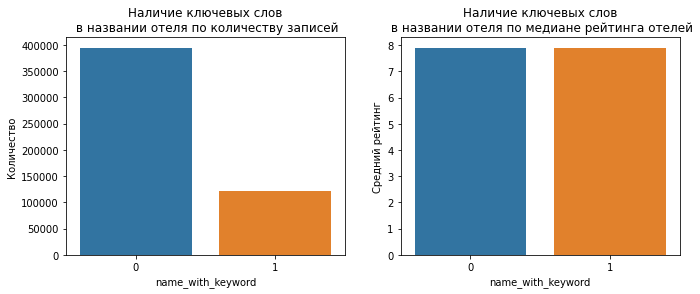

In [28]:
df = data.groupby('name_with_keyword')['reviewer_score'].agg(['count', 'median']).\
    reset_index('name_with_keyword')
df.columns = ['name_with_keyword', 'count_values', 'median_score']
visualization(df, 'name_with_keyword', 'Наличие ключевых слов\n в названии отеля', 0)

Судя по графикам, наличие ключевых слов в названии отеля не влияет на медиану оценки. При этом отелей с ключевыми словами существенно меньше, чем без них. Лучше сразу удалить данный признак.

In [29]:
data.drop('name_with_keyword', axis=1, inplace=True)

Создадим признак-мигалку, показывающий, совпадает ли страна рецензента со страной отеля

In [30]:
data['is_country_reviewer'] = data.apply(
    lambda row: 1 if row['reviewer_nationality'].strip() == row['hotel_country'] else 0, axis=1) 

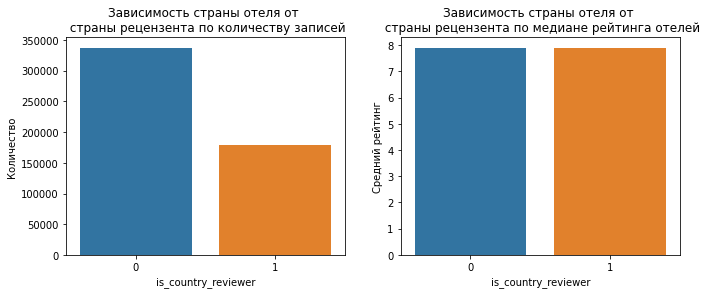

In [31]:
df = data.groupby('is_country_reviewer')['reviewer_score'].agg(['count', 'median']).\
    reset_index('is_country_reviewer')
visualization(df, 'is_country_reviewer', 'Зависимость страны отеля от \n страны рецензента', 0)

Исходя из визуального анализа можно сделать вывод, что рейтинг не зависит от совпадения страны рецензета и страны отеля. Удалим данный признак. 

In [32]:
data.drop('is_country_reviewer', axis=1, inplace=True)

Создадим признаки анализа тональности положительных и отрицательных отзывов

In [33]:
# Функция создания признаков для анализа настроений
def review_analyzer(feature_list):
    # Цикл по анализируемому списку признаков
    for feature in feature_list:
        hotel_review_list = data[feature].apply(
            lambda x: x.replace('No Positive', 'Negative').replace('No Negative', 'Positive'))
        
        # Создаем инструмент для анализа и словарь числовых значений
        sent_analyzer = SentimentIntensityAnalyzer()
        dict_analysis = defaultdict(list)

        # В цикле по строкам заполняем словарь
        for row in hotel_review_list:
            analysis_row = sent_analyzer.polarity_scores(row)
    
            for key in analysis_row:
                dict_analysis[key].append(analysis_row[key])
        
        # Создаём 4 признака настроений
        for key in dict_analysis:
            data[feature + '_' + key] = pd.Series(dict_analysis[key])
            
# Вызовем функцию анализа для признаков с отзывами           
review_analyzer(['negative_review', 'positive_review'])

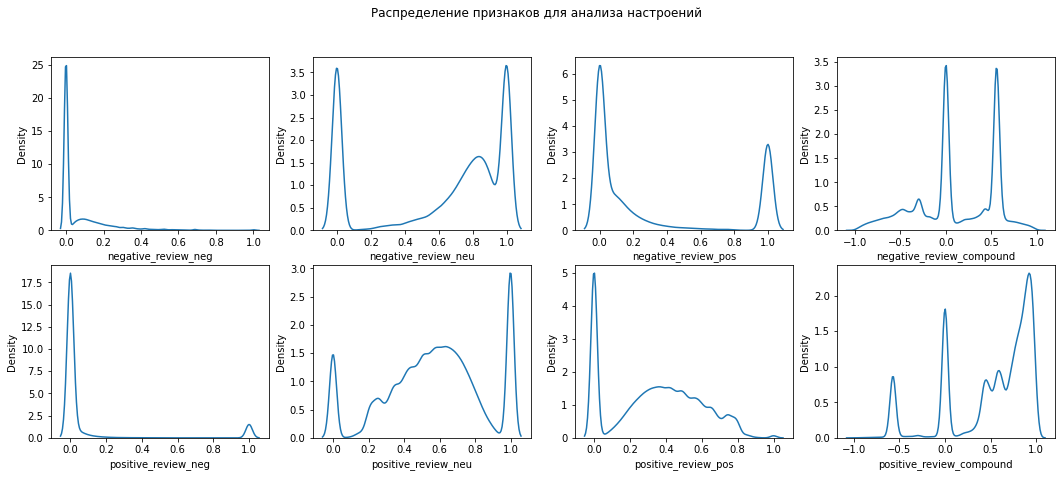

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))

cols = ['negative_review_neg', 'negative_review_neu',
        'negative_review_pos', 'negative_review_compound',
        'positive_review_neg', 'positive_review_neu', 
        'positive_review_pos', 'positive_review_compound']

for i in range(8):
    sns.kdeplot(data[cols[i]], ax=axes[i//4][i%4], label=cols[i])
    
plt.suptitle('Распределение признаков для анализа настроений');

Как можно судить по графикам, данные распределены ненормально. У большинства графиков пики распределения находятся в крайних значений - 0 и 1. Выделяются графики compound, там присутствуют пики около значений 0.5 и - 0.5.

Создадим признак количества тегов в отзыве

In [35]:
data['count_tags'] = data['tags'].apply(lambda x: len(x.split(',')))

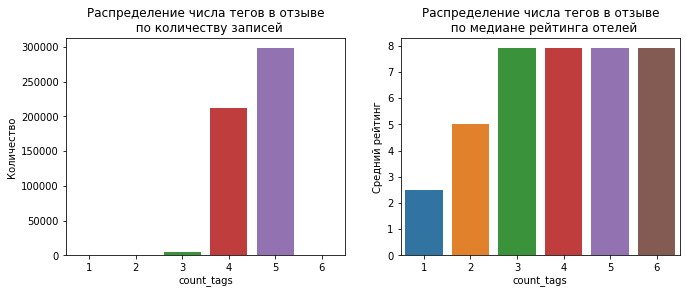

In [36]:
df = data.groupby('count_tags')['reviewer_score'].agg(['count', 'median']).\
    reset_index('count_tags')
visualization(df, 'count_tags', 'Распределение числа тегов в отзыве\n ', 0)

Как видно из графиков рейтинг растёт с увеличением числа тегов, но после трех тегов перестаёт расти. Максимальное количество записей у отзывов с 5 тегами.

Создадим признак наличия самого популярного тега

In [37]:
tags_string =', '.join(list(data['tags']))
tags_string = tags_string.replace('[', '').replace(']', '').replace('\'', '')
tags_list = tags_string.split(', ')
tag = pd.Series(tags_list).mode()[0]

data['tag_mode'] = data['tags'].apply(
    lambda x: 1 if x.find(tag.strip()) >= 0 else 0)

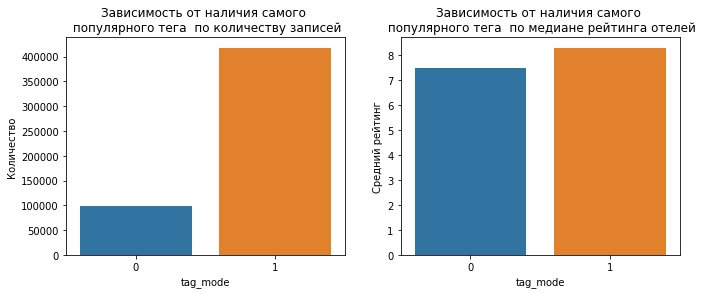

In [38]:
df = data.groupby('tag_mode')['reviewer_score'].agg(['count', 'median']).\
    reset_index('tag_mode')
visualization(df, 'tag_mode', 'Зависимость от наличия самого \n популярного тега ', 0)

На первый взгляд можно сказать, что наличие ключевого тега положительно сказывается на оценке отеля. С другой стороны данный тег содержится в большинстве отзывов.

Создадим признак количества ночей, проведенных в отеле

In [39]:
data['count_nights'] = data['tags'].str.findall('(\d*)\snight').str.get(0)
# пропущенные значения заменим на 1
data['count_nights'] = data['count_nights'].replace('', 1).replace(np.NaN, 1)
data['count_nights'] = data['count_nights'].astype('int64')

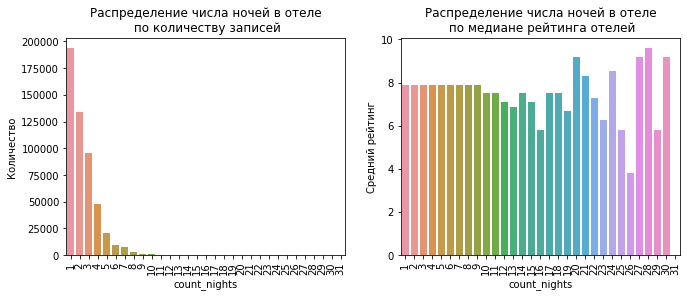

In [40]:
df = data.groupby('count_nights')['reviewer_score'].agg(['count', 'median']).\
    reset_index('count_nights')
visualization(df, 'count_nights', 'Распределение числа ночей в отеле\n', 90)

С увеличением числа ночей, проведенных в отделе, уменьшается количества соответсвтвующих записией. Также видно, что после 9 ночей медиана рейтинга начинается отличаться.

### Преобразование признаков

#### Кодирование признаков

In [41]:
# Закодируем признаки страны отеля и квартала, в котором был написан отзыв
categorical_columns_names = ['hotel_country', 'review_quarter']
data = pd.get_dummies(data, columns = categorical_columns_names, dtype=int)

#### Нормализация признаков

In [42]:
# Нормализуем признаки с выбросами при помощи RobustScaler
r_scaler = preprocessing.RobustScaler()
r_columns = ['lat', 'lng', 'additional_number_of_scoring', 'average_score',
             'review_total_negative_word_counts', 'total_number_of_reviews',
             'review_total_positive_word_counts',
             'total_number_of_reviews_reviewer_has_given',
             'count_tags', 'count_nights']

df_r = r_scaler.fit_transform(data[r_columns])
df_r = pd.DataFrame(df_r, columns=r_columns)

data = pd.concat([data, df_r], axis=1)

# Нормализуем признак без выбросов при помощи MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
mm_columns = ['days_since_review', 'hotel_country_Austria',
              'hotel_country_France', 'hotel_country_Italy',
              'hotel_country_Netherlands', 'hotel_country_Spain',
              'hotel_country_United Kingdom', 'review_quarter_1', 'review_quarter_2',
              'review_quarter_3', 'review_quarter_4']

df_mm = mm_scaler.fit_transform(data[mm_columns])
df_mm = pd.DataFrame(df_mm, columns=mm_columns)

data = pd.concat([data, df_mm], axis=1)

Удалим лишние признаки

In [43]:
object_columns = data.select_dtypes('object').columns
data.drop(object_columns, axis = 1, inplace=True)

In [44]:
# Переименуем признаки с одинаковым названием
data.columns = ['additional_number_of_scoring_old', 'average_score_old',
                'review_total_negative_word_counts_old', 'total_number_of_reviews_old',
                'review_total_positive_word_counts_old',
                'total_number_of_reviews_reviewer_has_given_old', 'days_since_review_old',
                'lat_old', 'lng_old', 'sample', 'reviewer_score', 'negative_review_neg',
                'negative_review_neu', 'negative_review_pos',
                'negative_review_compound', 'positive_review_neg',
                'positive_review_neu', 'positive_review_pos',
                'positive_review_compound', 'count_tags_old', 'tag_mode', 'count_nights_old',
                'hotel_country_Austria_old', 'hotel_country_France_old', 'hotel_country_Italy_old',
                'hotel_country_Netherlands_old', 'hotel_country_Spain_old',
                'hotel_country_United Kingdom_old', 'review_quarter_1_old', 'review_quarter_2_old',
                'review_quarter_3_old', 'review_quarter_4_old', 'lat', 'lng',
                'additional_number_of_scoring', 'average_score',
                'review_total_negative_word_counts', 'total_number_of_reviews',
                'review_total_positive_word_counts',
                'total_number_of_reviews_reviewer_has_given', 'count_tags',
                'count_nights', 'days_since_review', 'hotel_country_Austria',
                'hotel_country_France', 'hotel_country_Italy',
                'hotel_country_Netherlands', 'hotel_country_Spain',
                'hotel_country_United Kingdom', 'review_quarter_1', 'review_quarter_2',
                'review_quarter_3', 'review_quarter_4']

# Удаляем лишние признаки
cols = list(filter(lambda x: x[-4:] == '_old', data.columns))
data.drop(cols, axis=1, inplace=True)

### Отбор признаков

#### Корреляционный анализ

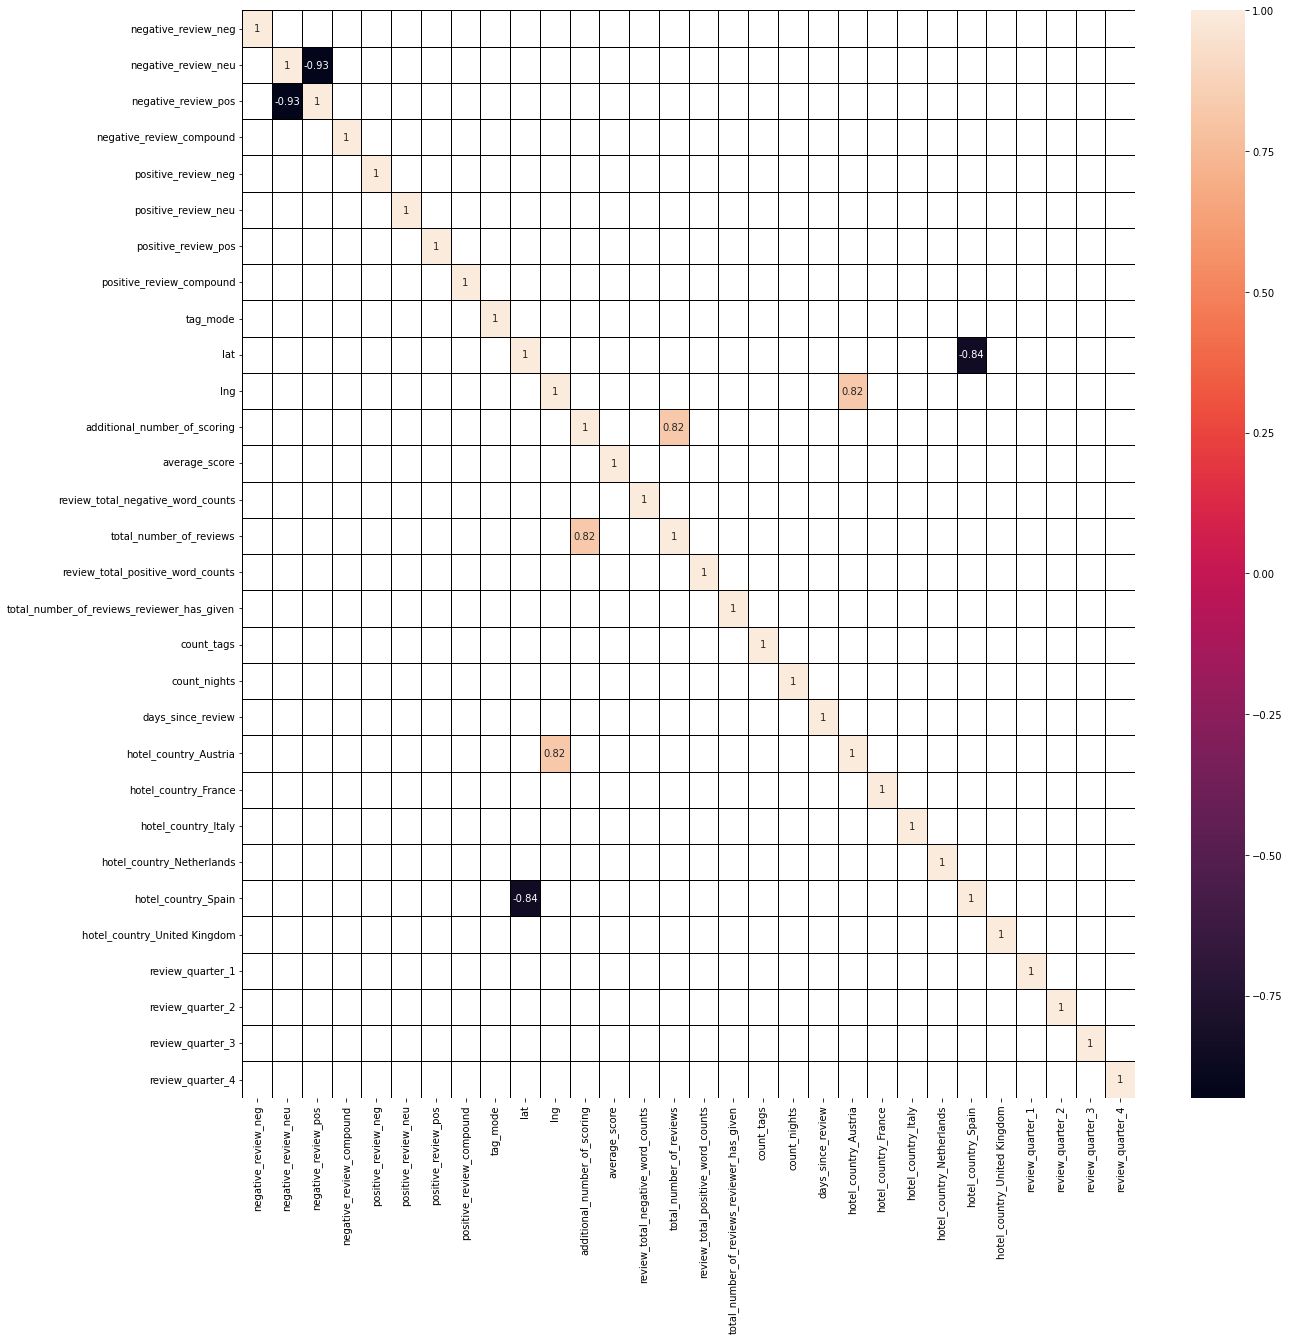

In [45]:
# Тепловая карта признаков с сильной корреляцией
data_corr = data.drop(['sample', 'reviewer_score'], axis=1)

fig, (ax1) = plt.subplots(ncols=1, figsize=(20, 20))
corr = data_corr.corr()
corr_strong = corr[abs(corr) >= 0.7]
sns.heatmap(corr_strong,  linewidths=0.5, linecolor='black', annot=True);

Корреляционный анализ показал 4 пары признаков с сильной корреляцией:

- negative_review_pos и negative_review_neu;
- total_number_of_reviews и additional_number_of_scoring;
- hotel_country_Austria и lng;
- hotel_country_Spain и lat.

Оценим значимость каждого признака и оставим самые информативные.

#### Оценка значимости каждого признака в определении рейтинга отеля

In [46]:
# Возьмём абсолютное значение широты и долготы
data['lat'] = abs(data['lat'])
data['lng'] = abs(data['lng'])

# Непрерывные признаки
num_cols = ['negative_review_neg', 'negative_review_neu', 'negative_review_pos',
            'negative_review_compound', 'positive_review_neg', 'positive_review_neu', 
            'positive_review_pos', 'positive_review_compound', 'lat', 'lng',
            'additional_number_of_scoring', 'average_score',
            'review_total_negative_word_counts', 'total_number_of_reviews',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given', 'count_tags',
            'count_nights', 'days_since_review']

# Категориальные признаки
cat_cols = ['tag_mode', 'hotel_country_Austria',
            'hotel_country_France', 'hotel_country_Italy',
            'hotel_country_Netherlands', 'hotel_country_Spain',
            'hotel_country_United Kingdom', 'review_quarter_1', 'review_quarter_2',
            'review_quarter_3', 'review_quarter_4']

In [47]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

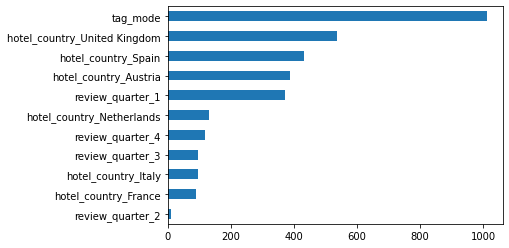

In [48]:
# Для оценки значимости категориальных переменных используем тест хи-квадрат
score = y.astype('int')

from sklearn.feature_selection import chi2

imp_cat = pd.Series(chi2(X[cat_cols], score)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

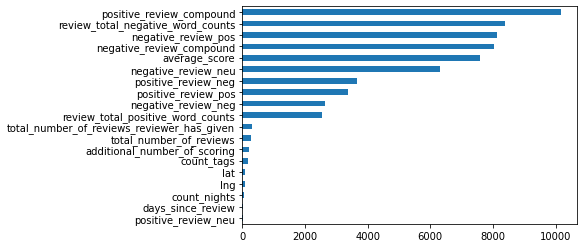

In [49]:
# Для оценки непрерывных переменных используем анализ ANOVA
from sklearn.feature_selection import f_classif

imp_num = pd.Series(f_classif(X[num_cols], score)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh');

На основании корреляционного анализа и оценки значимости удалим менее значимые признаки.

In [50]:
cols= ['negative_review_neu', 'positive_review_neu',
       'lat', 'lng', 'additional_number_of_scoring',
       'review_quarter_3', 'count_nights', 'days_since_review']

train_data = train_data.drop(cols, axis=1)
test_data = test_data.drop(cols, axis=1)

X = X.drop(cols, axis=1)

In [51]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [52]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 23), (386803, 23), (386803, 22), (309442, 22), (77361, 22))

In [53]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [54]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [55]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
#print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

In [56]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  

# Функция для вычисления MAPE
def mape_func(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print('MAPE:', mape_func(y_test, y_pred))

MAPE: 12.601665693701236


<AxesSubplot:>

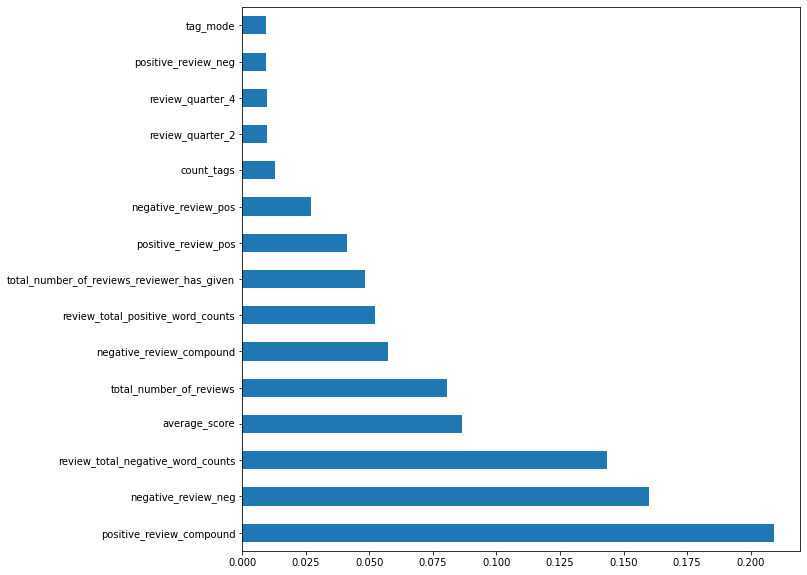

In [57]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [58]:
test_data.sample(10)

,reviewer_score,negative_review_neg,negative_review_pos,negative_review_compound,positive_review_neg,positive_review_pos,positive_review_compound,tag_mode,average_score,review_total_negative_word_counts,...,count_tags,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,review_quarter_1,review_quarter_2,review_quarter_4
89465,0.0,0.000,0.000,0.0000,0.0,0.474,0.4019,0,0.857143,0.047619,...,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12824,0.0,0.151,0.028,-0.7717,0.0,0.558,0.9757,1,0.142857,2.904762,...,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
47246,0.0,0.000,0.000,0.0000,0.0,0.800,0.9186,1,1.142857,-0.047619,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
105195,0.0,0.034,0.000,-0.1787,0.0,0.367,0.9732,1,-0.285714,2.142857,...,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
34101,0.0,0.000,1.000,0.5574,0.0,0.502,0.7939,1,0.000000,-0.428571,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15002,0.0,0.000,1.000,0.5574,0.0,0.199,0.8653,1,-1.571429,-0.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
86077,0.0,0.000,1.000,0.5574,0.0,0.321,0.9705,0,0.285714,-0.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
56445,0.0,0.184,0.000,-0.4466,0.0,0.387,0.8341,1,0.857143,0.523810,...,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32990,0.0,0.030,0.053,0.6966,0.0,0.292,0.9525,0,-0.285714,14.285714,...,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
60570,0.0,0.149,0.062,-0.4789,0.0,0.348,0.9595,1,0.857143,1.714286,...,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [59]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [60]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [61]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [62]:
predict_submission

array([8.516, 7.48 , 8.8  , ..., 8.277, 9.621, 6.707])

In [63]:
list(sample_submission)

['reviewer_score', 'id']

In [64]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.516,488440
1,7.480,274649
2,8.800,374688
3,9.762,404352
4,9.581,451596
5,9.058,302161
6,7.506,317079
7,7.505,13963
8,8.178,159785
9,7.385,195089


### Выводы по проекту:

В ходе выполнения проекта мы ознакомились с входными данными и подготовили 22 признака для обучения модели. Мы оценили эффективность модели на основании метрики MAPE, которая составили около 12.6 %. Наиболее важными признаками для данной модели оказались:

- признаки анализа тональности текста (positive_review_compound, negative_review_neg, negative_review_compound, positive_review_pos и negative_review_pos);
- общее количество слов в отрицательном отзыв (review_total_negative_word_counts);
- средний балл отеля (average_score);
- общее количество действительных отзывов об отеле (total_number_of_reviews);
- общее количество слов в положительном отзыве (review_total_positive_word_counts);
- количество отзывов, которые рецензенты дали в прошлом (total_number_of_reviews_reviewer_has_given).

Также приняли участие в соревновании Kaggle.
